In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path as P
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['font.size'] = 12  # 字体大小
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
from collections import defaultdict
import plotly.express as px
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [149]:
learning_rate=0.001
train_size=0.9
bs=1
epochs=500

YEAR,INTENSITY,BLOCK,SOC,SIC,STC,ALLN,CN=['year', '放牧强度（intensity）', '放牧小区（plot）', 'SOC土壤有机碳', 'SIC土壤无机碳',
       'STC土壤全碳', '全氮N', '土壤C/N比']

In [150]:
df_NUMERIC=pd.read_csv('./问题3-因变量.csv')
scaler=pickle.load(open('./问题3-scaler.pkl','rb'))
df_INPUT=pd.read_csv('./问题3-自变量.csv')
df_INDEX=pd.read_csv('./问题3-索引.csv')

In [151]:
df_NUMERIC.shape, df_INPUT.shape, scaler.mean_, scaler.scale_

((60, 5),
 (60, 13),
 array([14.92006485,  7.51246398, 22.43252883,  1.82556675, 13.00669993]),
 array([1.7068166 , 2.79228173, 2.43835697, 0.21700343, 2.45867866]))

In [152]:
X_train,X_val,Y_train,Y_val=train_test_split(df_INPUT.values, df_NUMERIC.values, train_size=train_size, shuffle=False)
# 开了shuffled后，性能会变差，不要开。

In [153]:
X_train.shape,X_val.shape,Y_train.shape,Y_val.shape

((54, 13), (6, 13), (54, 5), (6, 5))

In [154]:
inputs = keras.layers.Input(shape=(X_train.shape[1], ))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(Y_train.shape[1])(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_21 (Dense)            (None, 128)               1792      
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 18,949
Trainable params: 18,949
Non-trainable params: 0
_________________________________________________________________


In [155]:
path_checkpoint = "problem3_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    # 要同时保存网络结构。
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=[es_callback, modelckpt_callback],
    batch_size=bs
)

Epoch 1/500
45/54 [========================>.....] - ETA: 0s - loss: 0.7186 
Epoch 1: val_loss improved from inf to 1.21260, saving model to problem3_checkpoint.h5
54/54 [==============================] - 0s 4ms/step - loss: 0.8083 - val_loss: 1.2126
Epoch 2/500
43/54 [======================>.......] - ETA: 0s - loss: 0.5630
Epoch 2: val_loss improved from 1.21260 to 1.14197, saving model to problem3_checkpoint.h5
54/54 [==============================] - 0s 2ms/step - loss: 0.6036 - val_loss: 1.1420
Epoch 3/500
47/54 [=========================>....] - ETA: 0s - loss: 0.4449
Epoch 3: val_loss improved from 1.14197 to 0.89127, saving model to problem3_checkpoint.h5
54/54 [==============================] - 0s 2ms/step - loss: 0.4286 - val_loss: 0.8913
Epoch 4/500
37/54 [===================>..........] - ETA: 0s - loss: 0.3113
Epoch 4: val_loss improved from 0.89127 to 0.74076, saving model to problem3_checkpoint.h5
54/54 [==============================] - 0s 3ms/step - loss: 0.3416 - val_

Epoch 36/500
37/54 [===================>..........] - ETA: 0s - loss: 0.0566
Epoch 36: val_loss improved from 0.15656 to 0.15259, saving model to problem3_checkpoint.h5
54/54 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.1526
Epoch 37/500
 1/54 [..............................] - ETA: 0s - loss: 0.0252
Epoch 37: val_loss improved from 0.15259 to 0.13335, saving model to problem3_checkpoint.h5
54/54 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.1333
Epoch 38/500
 1/54 [..............................] - ETA: 0s - loss: 0.0163
Epoch 38: val_loss did not improve from 0.13335
54/54 [==============================] - 0s 1ms/step - loss: 0.0505 - val_loss: 0.1428
Epoch 39/500
 1/54 [..............................] - ETA: 0s - loss: 0.0269
Epoch 39: val_loss did not improve from 0.13335
54/54 [==============================] - 0s 1ms/step - loss: 0.0482 - val_loss: 0.1440
Epoch 40/500
53/54 [============================>.] - ETA: 0s - 

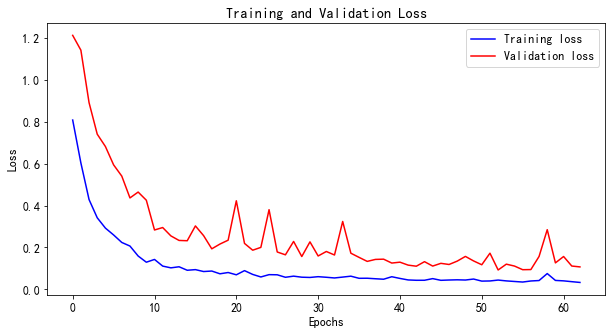

In [156]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [157]:
pred=model.predict(df_INPUT.values)
df_pred=pd.DataFrame(data=pred, columns=df_NUMERIC.columns)
df_pred[:]=scaler.inverse_transform(df_pred.values)
df_gnd=pd.DataFrame(data=scaler.inverse_transform(df_NUMERIC),columns=df_NUMERIC.columns)
PRED,GND='预测值','真实值'
df=df_pred.join(df_gnd, rsuffix=GND, lsuffix=PRED).join(df_INDEX)
df.to_csv('问题3-预测结果-训练集.csv', index=False)
df

,SOC土壤有机碳预测值,SIC土壤无机碳预测值,STC土壤全碳预测值,全氮N预测值,土壤C/N比预测值,SOC土壤有机碳真实值,SIC土壤无机碳真实值,STC土壤全碳真实值,全氮N真实值,土壤C/N比真实值,year,放牧强度（intensity）,放牧小区（plot）
0,12.122072,11.617398,23.722021,1.377414,17.407051,12.164092,11.550000,23.714092,1.378942,17.394695,2012,HGI,G13
1,13.154686,10.756615,23.885014,1.769801,14.118596,13.066348,10.849667,23.916014,1.752764,14.245073,2012,HGI,G20
2,13.613664,11.876972,25.475559,1.657758,16.922113,13.474534,11.875000,25.349534,1.648023,17.020659,2012,HGI,G9
3,12.300937,10.183835,22.495541,1.635048,14.293394,12.469286,10.491667,22.960953,1.648516,14.458516,2012,LGI,G12
4,12.291783,8.686108,20.976477,1.551275,13.813123,12.021940,8.925000,20.946940,1.537228,13.980016,2012,LGI,G18
5,14.345825,13.796214,28.165682,1.890249,15.082412,14.327432,13.958333,28.285766,1.895496,15.199783,2012,LGI,G6
6,14.465620,6.617682,21.086607,1.764842,12.334271,14.226167,6.712500,20.938667,1.749771,12.481757,2012,MGI,G11
7,11.915647,8.711841,20.627424,1.737852,11.944180,11.638731,8.950000,20.588731,1.698386,12.383591,2012,MGI,G16
8,13.785741,9.538039,23.296291,1.764886,13.369668,13.677481,9.541667,23.219148,1.763731,13.412295,2012,MGI,G8
9,14.225382,10.905369,25.107237,1.673620,15.923499,13.973544,10.950000,24.923544,1.659076,16.012928,2012,NG,G17


## 全体训练样本上的拟合效果

In [171]:
def plotPredGndSample(name, df):
    return px.line(df, y=[name+GND, name+PRED]
                  ).update_layout(title=f'{name}拟合效果',
                                  legend_title='预测值/真实值',yaxis_title='取值',xaxis_title='样本')
    

In [172]:
plotPredGndSample(SOC, df)

In [173]:
plotPredGndSample(SIC, df)

In [174]:
plotPredGndSample(STC, df)

In [175]:
plotPredGndSample(ALLN, df)

In [176]:
plotPredGndSample(CN, df)

## 不同放牧强度和小区的样本上的拟合效果

In [160]:
df_list=list(df.groupby([INTENSITY,BLOCK]))

In [177]:
def plotPredGnd(i, y):
    info, df = df_list[i]
    return px.line(df, x=YEAR, 
                   y=[y+GND,y+PRED]).update_layout(title=f'放牧强度{info[0]}下小区{info[1]}的{y}拟合效果',
                                                  yaxis_title='取值', xaxis_title='年份', legend_title='预测值/真实值')

In [180]:
plotPredGnd(2, SOC)

In [181]:
plotPredGnd(2, SIC)

In [182]:
plotPredGnd(2, STC)

In [183]:
plotPredGnd(2, ALLN)

In [184]:
plotPredGnd(2, CN)

In [185]:
plotPredGnd(2, SOC)